# Celebrity Face Swap (the poor man's DeepFake)
Recently we've seen [Nicholas Cage](https://www.youtube.com/watch?v=2jp4M1cIJ5A)'s face appear everywhere (for those who don't know what I'm talking about, please have a look)

In this script we will get familiar with:  
* image warping using [picewise-affine warp](https://scikit-image.org/docs/dev/auto_examples/transform/plot_piecewise_affine.html)
* [possion blending](https://cs.brown.edu/courses/csci1950-g/results/proj2/edwallac/) for seamless "pasting" of image parts into a full image

Specifically, we ask wheather we can build a very simple face swapping algorithm if we have just the facial landmaks for that face?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import cluster
from skimage import transform as tf
import glob
from skimage.morphology  import disk, erosion
from skimage.restoration import inpaint
import cv2
import os 
from skimage.measure import label, regionprops

np.random.seed(1)

base_folder = '../input/' 
csv_filename = 'youtube_faces_with_keypoints_full.csv'
videoDF = pd.read_csv(os.path.join(base_folder, csv_filename))

# create a dictionary that maps videoIDs to full file paths
npz_files_full_path = glob.glob(base_folder + 'youtube_faces_*/*/*.npz')
videoIDs = [x.split('/')[-1].split('.')[0] for x in npz_files_full_path]
full_paths = {}
for videoID, fullPath in zip(videoIDs, npz_files_full_path):
    full_paths[videoID] = fullPath

# remove from the large csv file all videos that weren't uploaded yet
videoDF = videoDF.loc[videoDF.loc[:,'videoID'].isin(full_paths.keys()),:].reset_index(drop=True)

# Apply Kmeans on the 2D shapes and present them (we will use them later)
Note that this is identical to what we did in the [exploration script](https://www.kaggle.com/selfishgene/exploring-youtube-faces-with-keypoints-dataset)

In [2]:
#%% collect all 2D landmarks and normlize them
NUM_LANDMARKS = 68
NUM_DIMS = 2

# shape normalization function
def normlize_shapes(shapes_im_coords):
    """shapes_normlized, scale_factors, mean_coords  = normlize_shapes(shapes_im_coords)"""
    (num_points, num_dims, _) = shapes_im_coords.shape

    # calc mean coords and subtract from shapes    
    mean_coords = shapes_im_coords.mean(axis=0)
    shapes_centered = np.zeros(shapes_im_coords.shape)
    shapes_centered = shapes_im_coords - np.tile(mean_coords,[num_points, 1, 1])

    # calc scale factors and divide shapes
    scale_factors = np.sqrt((shapes_centered**2).sum(axis=1)).mean(axis=0)
    shapes_normlized = np.zeros(shapes_centered.shape)
    shapes_normlized = shapes_centered / np.tile(scale_factors, [num_points, num_dims, 1])

    return shapes_normlized, scale_factors, mean_coords

# collect all 2D shapes from all frames from all videos to a single numpy array matrix
total_num_frames = videoDF['videoDuration'].sum()
landmarks2D_all = np.zeros((NUM_LANDMARKS, NUM_DIMS,int(total_num_frames)))
shape_ind_to_videoID_map = {} # dictionary for later useage

end_ind = 0
for i, videoID in enumerate(videoDF['videoID']):
    # load video
    video_file  = np.load(full_paths[videoID])
    landmarks2D = video_file['landmarks2D']

    start_ind = end_ind
    end_ind   = start_ind + landmarks2D.shape[2]

    # store in one big array
    landmarks2D_all[:,:,start_ind:end_ind] = landmarks2D

    # make sure we keep track of the mapping to the original video and frame
    for videoFrameInd, shapeInd in enumerate(range(start_ind,end_ind)):
        shape_ind_to_videoID_map[shapeInd] = (videoID, videoFrameInd)

# normlize shapes
landmarks2D_normlized, _, _  = normlize_shapes(landmarks2D_all)

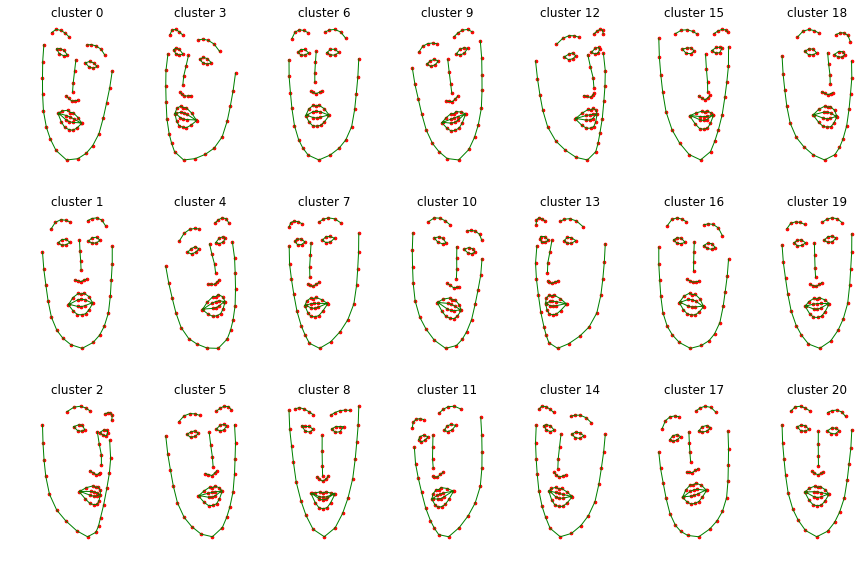

In [3]:
#%% apply kmeans on 2D shapes and show them (like we did in the exploration script)
num_cols = 7
num_rows = 3
num_clusters = num_cols * num_rows
normalized_shapes_table = np.reshape(landmarks2D_normlized, [NUM_LANDMARKS * NUM_DIMS, landmarks2D_normlized.shape[2]]).T

ShapesKmeansModel  = cluster.KMeans(n_clusters=num_clusters, n_init=5, random_state=1).fit(normalized_shapes_table)
cluster_assignment = ShapesKmeansModel.predict(normalized_shapes_table)

ShapesPCAModel = decomposition.PCA(n_components=30).fit(normalized_shapes_table)

# show the clusters
jaw_points           = range( 0,17)
rigth_eyebrow_points = range(17,22)
left_eyebrow_points  = range(22,27)
nose_ridge_points    = range(27,31)
nose_base_points     = range(31,36)
right_eye_points     = range(36,42)
left_eye_points      = range(42,48)
outer_mouth_points   = range(48,60)
inner_mouth_points   = range(60,68)

closing_right_eye   = [36,41]
closing_left_eye    = [42,47]
closing_outer_mouth = [48,59]
closing_inner_mouth = [60,67]

list_of_connected_points = [jaw_points, rigth_eyebrow_points, left_eyebrow_points, nose_ridge_points, nose_base_points,
                            right_eye_points, left_eye_points, outer_mouth_points, inner_mouth_points,
                            closing_right_eye, closing_left_eye, closing_outer_mouth, closing_inner_mouth]

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12,8))
for i in range(num_clusters):
    curr_landmarks2D = np.reshape(ShapesKmeansModel.cluster_centers_[i,:], [NUM_LANDMARKS, NUM_DIMS])
    ax[i%num_rows,i//num_rows].scatter(curr_landmarks2D[:,0], -curr_landmarks2D[:,1], c='r',s=7.0)
    for conPts in list_of_connected_points:
        xPts = curr_landmarks2D[conPts,0]
        yPts = curr_landmarks2D[conPts,1]
        ax[i % num_rows,i // num_rows].plot(xPts,-yPts,color='g',linewidth=1.0)         
    ax[i % num_rows, i // num_rows].set_title('cluster %d' %(i))
    ax[i % num_rows, i // num_rows].set_axis_off()
fig.tight_layout()


Define a helper function to warp image with a picewise affine tranform that we will use later

In [4]:
# warp image with a picewise affine transform
def warp_im_picewise_affine(src_im, src_coords, dst_coords, target_im_size=None):
    """warped_im = warp_im_picewise_affine(src_im, src_coords, dst_coords, target_im_size)"""
    requested_transfromation = tf.estimate_transform('piecewise-affine',src_coords,dst_coords)
    warped_im = tf.warp(src_im,requested_transfromation.inverse,output_shape=target_im_size)
    return warped_im

# Take a random frontal facing face and warp it to all other shape clusters

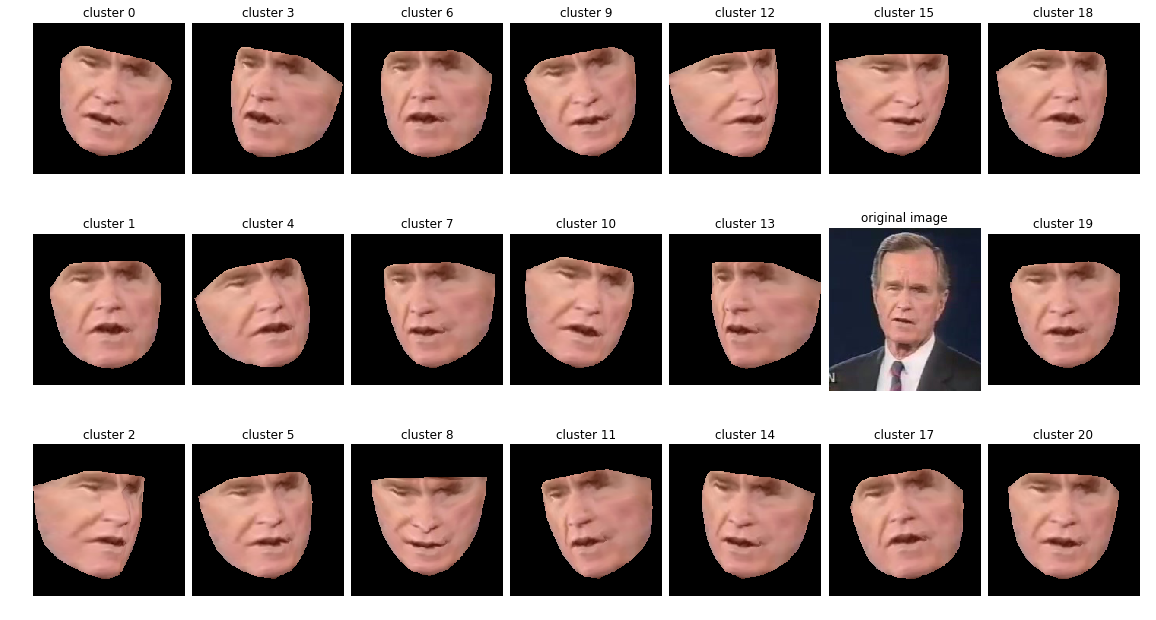

In [5]:
#%% take a random frontal face image and warp it's texture into all kmeans shapes to demonstrate picewise affine warping
np.random.seed(1)

# get shape ids only of large faces
large_faces_videoIDs = videoDF.loc[videoDF['averageFaceSize'] > 80, 'videoID'].tolist()
shape_ind_large_face_only = []
for key, value in shape_ind_to_videoID_map.items():
    if value[0] in large_faces_videoIDs:
        shape_ind_large_face_only.append(key)
shape_ind_large_face_only = np.array(shape_ind_large_face_only)
        
overlay_landmarks = False
frontal_shape_cluster_ind = 16
frontal_inds = np.nonzero(cluster_assignment == frontal_shape_cluster_ind)[0]
frontal_inds = np.array(list(set(frontal_inds).intersection(set(shape_ind_large_face_only))))

some_frontal_image_ind = np.random.choice(frontal_inds,size=1)[0]

selected_videoID = shape_ind_to_videoID_map[some_frontal_image_ind][0]
selected_video_frame = shape_ind_to_videoID_map[some_frontal_image_ind][1]

video_file = np.load(full_paths[selected_videoID])
selected_frontal_image = video_file['colorImages'][:,:,:,selected_video_frame]
selected_frontal_shape = video_file['landmarks2D'][:,:,selected_video_frame]

#plt.figure(); plt.imshow(selected_frontal_image); plt.scatter(selected_frontal_shape[:,0],selected_frontal_shape[:,1])

plt.close('all')
fig, ax = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=(16,9))
for i in range(num_clusters):
    curr_landmarks2D_norm = np.reshape(ShapesKmeansModel.cluster_centers_[i,:], [NUM_LANDMARKS,NUM_DIMS])
    
    # project the shape and reconstruct using the PCA model (to correct small shape jitter)
    curr_landmarks2D_norm_rec = ShapesPCAModel.transform(curr_landmarks2D_norm.reshape([1,NUM_LANDMARKS*NUM_DIMS]))
    curr_landmarks2D_norm_rec = ShapesPCAModel.inverse_transform(curr_landmarks2D_norm_rec)
    curr_landmarks2D_norm_rec = curr_landmarks2D_norm_rec.reshape([NUM_LANDMARKS,NUM_DIMS])
    
    # tranform to image coordinates
    curr_landmarks2D =  50 * curr_landmarks2D_norm_rec
    curr_landmarks2D += 100
    
    if i == frontal_shape_cluster_ind:
        # when the desired cluster is frontal, just show the original image
        ax[i % num_rows, i // num_rows].imshow(selected_frontal_image)
        ax[i % num_rows, i // num_rows].set_title('original image')
    else:
        # else, warp the image to the desired cluster
        warped_im = warp_im_picewise_affine(selected_frontal_image, selected_frontal_shape, curr_landmarks2D, target_im_size=[200,200])
        ax[i % num_rows, i // num_rows].imshow(warped_im)
        ax[i % num_rows, i // num_rows].set_title('cluster %d' %(i))
        
        # show the landmarks
        if overlay_landmarks:
            ax[i % num_rows, i // num_rows].scatter(curr_landmarks2D[:,0], curr_landmarks2D[:,1], c='r', s=1.3)
            for conPts in list_of_connected_points:
                xPts = curr_landmarks2D[conPts,0]
                yPts = curr_landmarks2D[conPts,1]
                ax[i % num_rows, i // num_rows].plot(xPts,yPts,color='g',linewidth=0.6)
    
    ax[i % num_rows,i // num_rows].set_axis_off()
fig.tight_layout()
fig.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.98, wspace=0.05, hspace=0.05)


We can see that just warping the texture of an image in this way can result in some **realistic looking faces** at new poses

### Define a helper function to embed an image in another image and inpaint the boards of the original image for smoother transition between the textures

In [6]:
# overlay image and inpaint boarders
def embed_image_in_another_image(image_to_embed, target_image, inpaint_boarders=True):
    assert(image_to_embed.shape[0] == target_image.shape[0])
    assert(image_to_embed.shape[1] == target_image.shape[1])
    
    # get the embedding mask (any non black color will be considered)
    embedding_mask = np.any(image_to_embed, axis=2)
    
    # overlay on top of original image
    overlayed_im = target_image.copy()
    if image_to_embed.dtype in [np.float16, np.float32, np.float64]:
        overlayed_im[embedding_mask] = 255 * image_to_embed[embedding_mask]
    else:
        overlayed_im[embedding_mask] = image_to_embed[embedding_mask]

    # do very basic inpainting
    if inpaint_boarders:
        # erode the mask a little bit
        embedding_mask_eroded = erosion(embedding_mask, disk(3.5))    
        embedding_mask_boundry = np.bitwise_and(embedding_mask, 
                                                np.logical_not(embedding_mask_eroded))
        # inpaint the boarder of the image so that we have a smoother transition between the embeded image and target
        overlayed_im = inpaint.inpaint_biharmonic(overlayed_im, embedding_mask_boundry, 
                                                  multichannel=True)

    return overlayed_im

In [7]:
def interpret_using_shape_model(ShapesPCAModel, shape):
    # normlize shape
    shape_norm, scale, trans = normlize_shapes(shape[:,:,np.newaxis])
    
    # project the shape and reconstruct using the PCA model (to correct small shape jitter)
    shape_norm_rec = ShapesPCAModel.inverse_transform(ShapesPCAModel.transform(shape_norm.reshape([1,NUM_LANDMARKS*NUM_DIMS])))
    shape_norm_rec = shape_norm_rec.reshape([NUM_LANDMARKS,NUM_DIMS])
    
    # tranform back to image coordinates
    shape_rec = scale[0]*shape_norm_rec
    shape_rec[:,0] += trans[0,0]
    shape_rec[:,1] += trans[1,0]

    return shape_rec

# Swap Celebrity Faces
We constrain ourselves here to non extreeme face poses here since they create warping artifacts

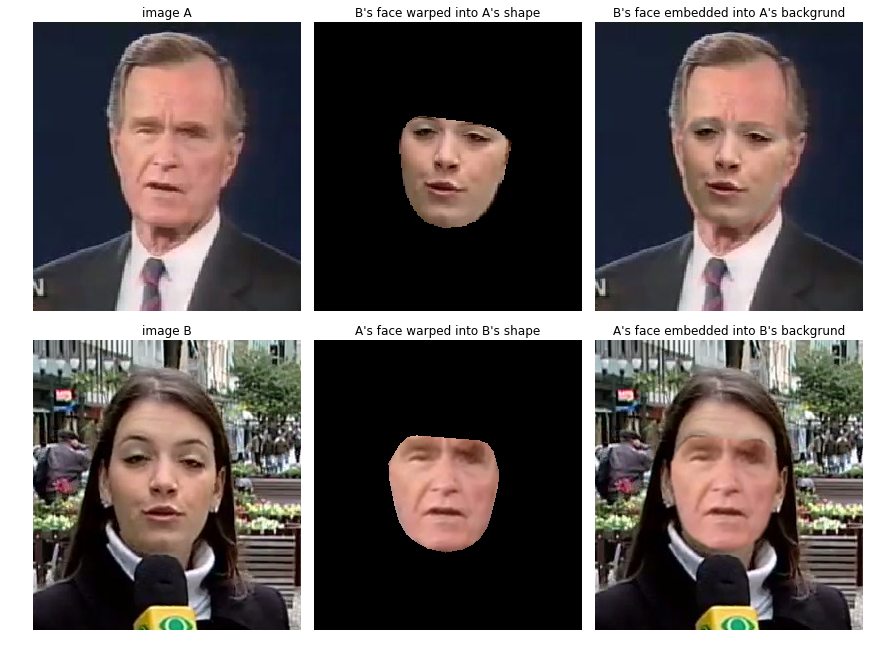

In [8]:
#%% take two almost frontal celebrity images and swap their faces
np.random.seed(1)

# choose some candidate images
almost_frontal_shape_cluster_inds = [0,1,5,6,8,9,10,11,14,15,16,17,18,19,20]
almost_frontal_inds = np.nonzero([x in almost_frontal_shape_cluster_inds for x in cluster_assignment])[0]
almost_frontal_inds = np.array(list(set(almost_frontal_inds).intersection(set(shape_ind_large_face_only))))

some_frontal_image_inds = np.random.choice(frontal_inds,size=2)
selected_videoID_A     = shape_ind_to_videoID_map[some_frontal_image_inds[0]][0]
selected_video_frame_A = shape_ind_to_videoID_map[some_frontal_image_inds[0]][1]
selected_videoID_B     = shape_ind_to_videoID_map[some_frontal_image_inds[1]][0]
selected_video_frame_B = shape_ind_to_videoID_map[some_frontal_image_inds[1]][1]

# load image A
video_file_A = np.load(full_paths[selected_videoID_A])
image_A = video_file_A['colorImages'][:,:,:,selected_video_frame_A]
shape_A = video_file_A['landmarks2D'][:,:,selected_video_frame_A]
shape_A = interpret_using_shape_model(ShapesPCAModel, shape_A)
image_A_size = image_A.shape[:2]

# load image B
video_file_B = np.load(full_paths[selected_videoID_B])
image_B = video_file_B['colorImages'][:,:,:,selected_video_frame_B]
shape_B = video_file_B['landmarks2D'][:,:,selected_video_frame_B]
shape_B = interpret_using_shape_model(ShapesPCAModel, shape_B)
image_B_size = image_B.shape[:2]

# warp faces into the other shape
A_warped_into_B = warp_im_picewise_affine(image_A, shape_A, shape_B, target_im_size=image_B_size)
B_warped_into_A = warp_im_picewise_affine(image_B, shape_B, shape_A, target_im_size=image_A_size)

# embed the faces in the target image
A_embedded_into_B = embed_image_in_another_image(A_warped_into_B, image_B)
B_embedded_into_A = embed_image_in_another_image(B_warped_into_A, image_A)

# plot
plt.figure(figsize=(12,9))
plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.98, wspace=0.05, hspace=0.05)
plt.subplot(2,3,1); plt.imshow(image_A); plt.title('image A'); plt.axis('off');
plt.subplot(2,3,2); plt.imshow(B_warped_into_A); plt.title("B's face warped into A's shape"); plt.axis('off');
plt.subplot(2,3,3); plt.imshow(B_embedded_into_A); plt.title("B's face embedded into A's backgrund"); plt.axis('off');
plt.subplot(2,3,4); plt.imshow(image_B); plt.title('image B'); plt.axis('off');
plt.subplot(2,3,5); plt.imshow(A_warped_into_B); plt.title("A's face warped into B's shape"); plt.axis('off');
plt.subplot(2,3,6); plt.imshow(A_embedded_into_B); plt.title("A's face embedded into B's backgrund"); plt.axis('off');


We can see that there are some large **lighting conditions** and **skin color variations** between the photos that are not accounted for.  
Nevertheless, the results are quite amusing :-)

**Note**, however, that by using piecewise-affine warping the shapes are very nicely aligned.  
Also, you can try changing the random seed and look at few other swaps. some of them are quite fun.

# Now, let's apply very simple texture normalization step and see the results
Just replace the mean and std of the absolut deviation from the mean of each (R,G,B) pixel value of the embeded face to match the source face

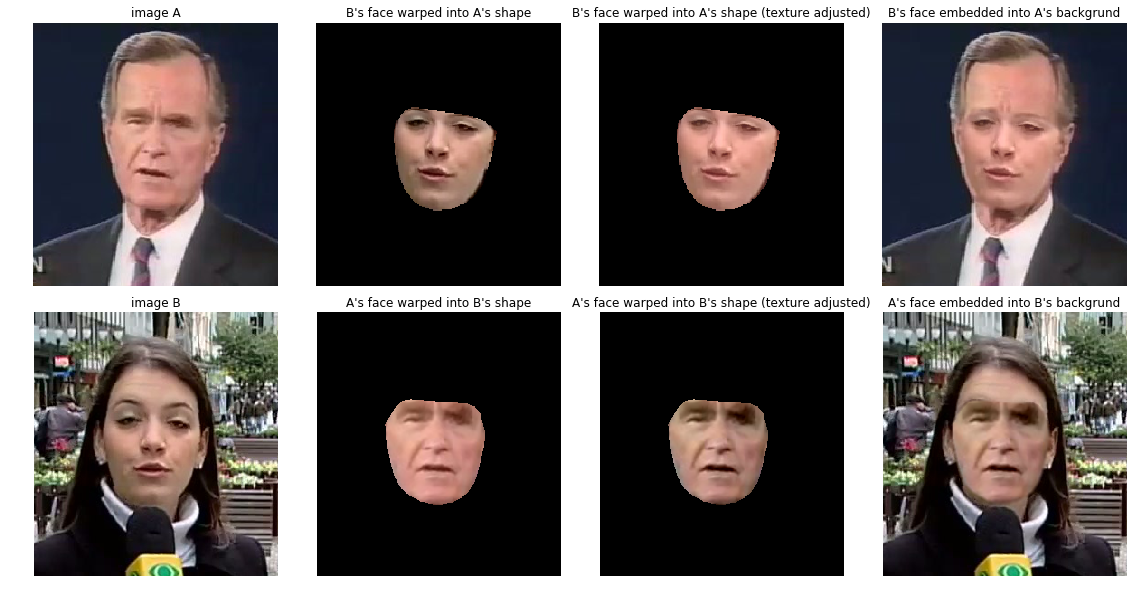

In [9]:
#%% take two almost frontal celebrity images and swap their faces
np.random.seed(1)

# choose some candidate images
almost_frontal_shape_cluster_inds = [0,1,5,6,8,9,10,11,14,15,16,17,18,19,20]
almost_frontal_inds = np.nonzero([x in almost_frontal_shape_cluster_inds for x in cluster_assignment])[0]
almost_frontal_inds = np.array(list(set(almost_frontal_inds).intersection(set(shape_ind_large_face_only))))

some_frontal_image_inds = np.random.choice(frontal_inds,size=2)
selected_videoID_A     = shape_ind_to_videoID_map[some_frontal_image_inds[0]][0]
selected_video_frame_A = shape_ind_to_videoID_map[some_frontal_image_inds[0]][1]
selected_videoID_B     = shape_ind_to_videoID_map[some_frontal_image_inds[1]][0]
selected_video_frame_B = shape_ind_to_videoID_map[some_frontal_image_inds[1]][1]

# load image A
video_file_A = np.load(full_paths[selected_videoID_A])
image_A = video_file_A['colorImages'][:,:,:,selected_video_frame_A]
shape_A = video_file_A['landmarks2D'][:,:,selected_video_frame_A]
shape_A = interpret_using_shape_model(ShapesPCAModel, shape_A)
image_A_size = image_A.shape[:2]

# load image B
video_file_B = np.load(full_paths[selected_videoID_B])
image_B = video_file_B['colorImages'][:,:,:,selected_video_frame_B]
shape_B = video_file_B['landmarks2D'][:,:,selected_video_frame_B]
shape_B = interpret_using_shape_model(ShapesPCAModel, shape_B)
image_B_size = image_B.shape[:2]

# warp faces into the other shape
A_warped_into_B = warp_im_picewise_affine(image_A, shape_A, shape_B, target_im_size=image_B_size)
B_warped_into_A = warp_im_picewise_affine(image_B, shape_B, shape_A, target_im_size=image_A_size)

### equate the mean and variance of the textures

# calculate the support mask for each warped image
A_warped_into_B_mask = np.any(A_warped_into_B, axis=2)
B_warped_into_A_mask = np.any(B_warped_into_A, axis=2)

# calculate the mean and std
A_texture_pixels = A_warped_into_B[A_warped_into_B_mask]
A_texture_mean   = A_texture_pixels.mean(axis=0)
A_texture_std    = np.sqrt(np.sum(A_texture_pixels**2,axis=1)).std()
B_texture_pixels = B_warped_into_A[B_warped_into_A_mask]
B_texture_mean   = B_texture_pixels.mean(axis=0)
B_texture_std    = np.sqrt(np.sum(B_texture_pixels**2,axis=1)).std()

# normalize the textures
A_texture_pixels_norm = A_texture_pixels - np.tile(A_texture_mean[np.newaxis,:],[A_texture_pixels.shape[0],1])
A_texture_pixels_norm /= A_texture_std
B_texture_pixels_norm = B_texture_pixels - np.tile(B_texture_mean[np.newaxis,:],[B_texture_pixels.shape[0],1])
B_texture_pixels_norm /= B_texture_std

# switch the means and stds
B_texture_pixels_adjusted = B_texture_pixels_norm * A_texture_std
B_texture_pixels_adjusted = B_texture_pixels_adjusted + np.tile(A_texture_mean[np.newaxis,:],[B_texture_pixels.shape[0],1])
A_texture_pixels_adjusted = A_texture_pixels_norm * B_texture_std
A_texture_pixels_adjusted = A_texture_pixels_adjusted + np.tile(B_texture_mean[np.newaxis,:],[A_texture_pixels.shape[0],1])

# place back 
A_warped_into_B_adjusted = A_warped_into_B.copy()
A_warped_into_B_adjusted[A_warped_into_B_mask] = A_texture_pixels_adjusted
A_warped_into_B_adjusted[A_warped_into_B_adjusted < 0] = 0
A_warped_into_B_adjusted[A_warped_into_B_adjusted > 1] = 1

B_warped_into_A_adjusted = B_warped_into_A.copy()
B_warped_into_A_adjusted[B_warped_into_A_mask] = B_texture_pixels_adjusted
B_warped_into_A_adjusted[B_warped_into_A_adjusted < 0] = 0
B_warped_into_A_adjusted[B_warped_into_A_adjusted > 1] = 1

# finally, embed the adjusted faces inside the target image
A_embedded_into_B = embed_image_in_another_image(A_warped_into_B_adjusted, image_B)
B_embedded_into_A = embed_image_in_another_image(B_warped_into_A_adjusted, image_A)

plt.figure(figsize=(16,8))
plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.98, wspace=0.1, hspace=0.1)
plt.subplot(2,4,1); plt.imshow(image_A); plt.title('image A'); plt.axis('off');
plt.subplot(2,4,2); plt.imshow(B_warped_into_A); plt.title("B's face warped into A's shape"); plt.axis('off');
plt.subplot(2,4,3); plt.imshow(B_warped_into_A_adjusted); plt.title("B's face warped into A's shape (texture adjusted)"); plt.axis('off');
plt.subplot(2,4,4); plt.imshow(B_embedded_into_A); plt.title("B's face embedded into A's backgrund"); plt.axis('off');
plt.subplot(2,4,5); plt.imshow(image_B); plt.title('image B'); plt.axis('off');
plt.subplot(2,4,6); plt.imshow(A_warped_into_B); plt.title("A's face warped into B's shape"); plt.axis('off');
plt.subplot(2,4,7); plt.imshow(A_warped_into_B_adjusted); plt.title("A's face warped into B's shape (texture adjusted)"); plt.axis('off');
plt.subplot(2,4,8); plt.imshow(A_embedded_into_B); plt.title("A's face embedded into B's backgrund"); plt.axis('off');

We can see the results are much better now, achived with just a simple texture normalization step in addition to a piecewise affine warp.



# Finally, let's apply Poission Blending to seamlessly paste the image
Please see [here](http://cs.brown.edu/courses/cs129/results/proj2/taox/), [here](https://cs.brown.edu/courses/csci1950-g/results/proj2/edwallac/) and original paper [here](http://www.cs.virginia.edu/~connelly/class/2014/comp_photo/proj2/poisson.pdf) for more information about poission blending

In [10]:
def apply_aligned_poission_blending(background_image, foreground_image, foreground_mask):
    # this function assumes that "background_image.shape" == "foreground_image.shape" == "foreground_mask.shape"
    # also that "background_image.dtype" == "foreground_image.dtype" == np.uint8

    # erode the mask by 3 pixels
    kernel_morph    = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    foreground_mask = cv2.erode(foreground_mask.astype(np.uint8), kernel_morph, iterations=1) 

    # make sure the mask is not problematic at boarders
    foreground_mask[0,:]  = False
    foreground_mask[:,0]  = False
    foreground_mask[-1,:] = False
    foreground_mask[:,-1] = False

    mask_label_image = label(foreground_mask)
    regions = regionprops(mask_label_image)
    min_row, min_col, max_row, max_col = regions[0].bbox

    if (min_row + max_row) % 2 == 1:
        min_row -= 1
    if (min_col + max_col) % 2 == 1:
        min_col -= 1

    center = (int((min_col + max_col) / 2), int((min_row + max_row) / 2))
    new_face_im_cropped   = foreground_image[min_row:max_row,min_col:max_col]
    new_face_mask_cropped = (255.0*foreground_mask[min_row:max_row,min_col:max_col]).astype(np.uint8)

    blended_image = cv2.seamlessClone(new_face_im_cropped, background_image, new_face_mask_cropped.copy(), center, cv2.NORMAL_CLONE)

    return blended_image

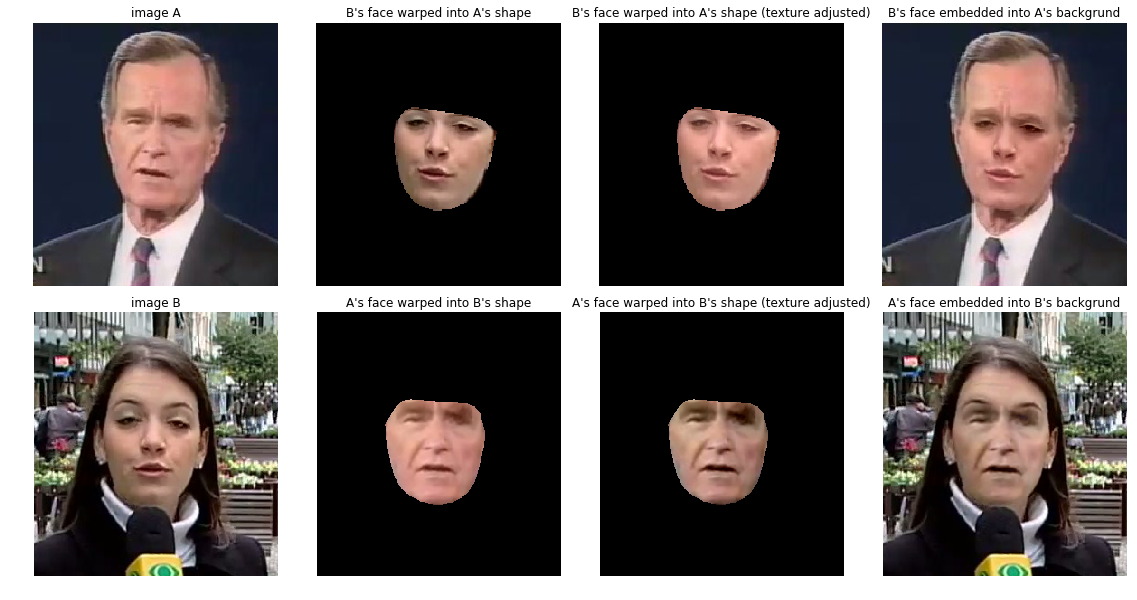

In [11]:
#%% take two almost frontal celebrity images and swap their faces
np.random.seed(1)

# choose some candidate images
almost_frontal_shape_cluster_inds = [0,1,5,6,8,9,10,11,14,15,16,17,18,19,20]
almost_frontal_inds = np.nonzero([x in almost_frontal_shape_cluster_inds for x in cluster_assignment])[0]
almost_frontal_inds = np.array(list(set(almost_frontal_inds).intersection(set(shape_ind_large_face_only))))

some_frontal_image_inds = np.random.choice(frontal_inds,size=2)
selected_videoID_A     = shape_ind_to_videoID_map[some_frontal_image_inds[0]][0]
selected_video_frame_A = shape_ind_to_videoID_map[some_frontal_image_inds[0]][1]
selected_videoID_B     = shape_ind_to_videoID_map[some_frontal_image_inds[1]][0]
selected_video_frame_B = shape_ind_to_videoID_map[some_frontal_image_inds[1]][1]

# load image A
video_file_A = np.load(full_paths[selected_videoID_A])
image_A = video_file_A['colorImages'][:,:,:,selected_video_frame_A]
shape_A = video_file_A['landmarks2D'][:,:,selected_video_frame_A]
shape_A = interpret_using_shape_model(ShapesPCAModel, shape_A)
image_A_size = image_A.shape[:2]

# load image B
video_file_B = np.load(full_paths[selected_videoID_B])
image_B = video_file_B['colorImages'][:,:,:,selected_video_frame_B]
shape_B = video_file_B['landmarks2D'][:,:,selected_video_frame_B]
shape_B = interpret_using_shape_model(ShapesPCAModel, shape_B)
image_B_size = image_B.shape[:2]

# warp faces into the other shape
A_warped_into_B = warp_im_picewise_affine(image_A, shape_A, shape_B, target_im_size=image_B_size)
B_warped_into_A = warp_im_picewise_affine(image_B, shape_B, shape_A, target_im_size=image_A_size)

### equate the mean and variance of the textures

# calculate the support mask for each warped image
A_warped_into_B_mask = np.any(A_warped_into_B, axis=2)
B_warped_into_A_mask = np.any(B_warped_into_A, axis=2)

# calculate the mean and std
A_texture_pixels = A_warped_into_B[A_warped_into_B_mask]
A_texture_mean   = A_texture_pixels.mean(axis=0)
A_texture_std    = np.sqrt(np.sum(A_texture_pixels**2,axis=1)).std()
B_texture_pixels = B_warped_into_A[B_warped_into_A_mask]
B_texture_mean   = B_texture_pixels.mean(axis=0)
B_texture_std    = np.sqrt(np.sum(B_texture_pixels**2,axis=1)).std()

# normalize the textures
A_texture_pixels_norm = A_texture_pixels - np.tile(A_texture_mean[np.newaxis,:], [A_texture_pixels.shape[0], 1])
A_texture_pixels_norm /= A_texture_std
B_texture_pixels_norm = B_texture_pixels - np.tile(B_texture_mean[np.newaxis,:], [B_texture_pixels.shape[0], 1])
B_texture_pixels_norm /= B_texture_std

# switch the means and stds
B_texture_pixels_adjusted = B_texture_pixels_norm * A_texture_std
B_texture_pixels_adjusted = B_texture_pixels_adjusted + np.tile(A_texture_mean[np.newaxis,:], [B_texture_pixels.shape[0], 1])
A_texture_pixels_adjusted = A_texture_pixels_norm * B_texture_std
A_texture_pixels_adjusted = A_texture_pixels_adjusted + np.tile(B_texture_mean[np.newaxis,:], [A_texture_pixels.shape[0], 1])

# place back 
A_warped_into_B_adjusted = A_warped_into_B.copy()
A_warped_into_B_adjusted[A_warped_into_B_mask] = A_texture_pixels_adjusted
A_warped_into_B_adjusted[A_warped_into_B_adjusted < 0] = 0
A_warped_into_B_adjusted[A_warped_into_B_adjusted > 1] = 1

B_warped_into_A_adjusted = B_warped_into_A.copy()
B_warped_into_A_adjusted[B_warped_into_A_mask] = B_texture_pixels_adjusted
B_warped_into_A_adjusted[B_warped_into_A_adjusted < 0] = 0
B_warped_into_A_adjusted[B_warped_into_A_adjusted > 1] = 1

B_warped_into_A_adjusted = (255 * B_warped_into_A_adjusted).astype(np.uint8)
A_warped_into_B_adjusted = (255 * A_warped_into_B_adjusted).astype(np.uint8)

# finally, embed the adjusted faces inside the target image
A_warped_into_B_adjusted_mask = np.any(A_warped_into_B_adjusted, axis=2)
B_warped_into_A_adjusted_mask = np.any(B_warped_into_A_adjusted, axis=2)

A_embedded_into_B = apply_aligned_poission_blending(image_B, A_warped_into_B_adjusted, A_warped_into_B_adjusted_mask)
B_embedded_into_A = apply_aligned_poission_blending(image_A, B_warped_into_A_adjusted, B_warped_into_A_adjusted_mask)

plt.figure(figsize=(16,8))
plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.98, wspace=0.1, hspace=0.1)
plt.subplot(2,4,1); plt.imshow(image_A); plt.title('image A'); plt.axis('off');
plt.subplot(2,4,2); plt.imshow(B_warped_into_A); plt.title("B's face warped into A's shape"); plt.axis('off');
plt.subplot(2,4,3); plt.imshow(B_warped_into_A_adjusted); plt.title("B's face warped into A's shape (texture adjusted)"); plt.axis('off');
plt.subplot(2,4,4); plt.imshow(B_embedded_into_A); plt.title("B's face embedded into A's backgrund"); plt.axis('off');
plt.subplot(2,4,5); plt.imshow(image_B); plt.title('image B'); plt.axis('off');
plt.subplot(2,4,6); plt.imshow(A_warped_into_B); plt.title("A's face warped into B's shape"); plt.axis('off');
plt.subplot(2,4,7); plt.imshow(A_warped_into_B_adjusted); plt.title("A's face warped into B's shape (texture adjusted)"); plt.axis('off');
plt.subplot(2,4,8); plt.imshow(A_embedded_into_B); plt.title("A's face embedded into B's backgrund"); plt.axis('off');

### We can see the blending is very good and no clear pasting marks exist

# Let's now repeat this process for several more image pairs

In [12]:
def face_swap(image_A, shape_A, image_B, shape_B):
    
    image_A_size = image_A.shape[:2]
    image_B_size = image_B.shape[:2]

    # warp faces into the other shape
    A_warped_into_B = warp_im_picewise_affine(image_A, shape_A, shape_B, target_im_size=image_B_size)
    B_warped_into_A = warp_im_picewise_affine(image_B, shape_B, shape_A, target_im_size=image_A_size)

    ### equate the mean and variance of the textures

    # calculate the support mask for each warped image
    A_warped_into_B_mask = np.any(A_warped_into_B, axis=2)
    B_warped_into_A_mask = np.any(B_warped_into_A, axis=2)

    # calculate the mean and std
    A_texture_pixels = A_warped_into_B[A_warped_into_B_mask]
    A_texture_mean   = A_texture_pixels.mean(axis=0)
    A_texture_std    = np.sqrt(np.sum(A_texture_pixels**2, axis=1)).std()
    B_texture_pixels = B_warped_into_A[B_warped_into_A_mask]
    B_texture_mean   = B_texture_pixels.mean(axis=0)
    B_texture_std    = np.sqrt(np.sum(B_texture_pixels**2, axis=1)).std()

    # normalize the textures
    A_texture_pixels_norm = A_texture_pixels - np.tile(A_texture_mean[np.newaxis,:], [A_texture_pixels.shape[0], 1])
    A_texture_pixels_norm /= A_texture_std
    B_texture_pixels_norm = B_texture_pixels - np.tile(B_texture_mean[np.newaxis,:], [B_texture_pixels.shape[0], 1])
    B_texture_pixels_norm /= B_texture_std

    # switch the means and stds
    B_texture_pixels_adjusted = B_texture_pixels_norm * A_texture_std
    B_texture_pixels_adjusted = B_texture_pixels_adjusted + np.tile(A_texture_mean[np.newaxis,:], [B_texture_pixels.shape[0], 1])
    A_texture_pixels_adjusted = A_texture_pixels_norm * B_texture_std
    A_texture_pixels_adjusted = A_texture_pixels_adjusted + np.tile(B_texture_mean[np.newaxis,:], [A_texture_pixels.shape[0], 1])

    # palce back 
    A_warped_into_B_adjusted = A_warped_into_B.copy()
    A_warped_into_B_adjusted[A_warped_into_B_mask] = A_texture_pixels_adjusted
    A_warped_into_B_adjusted[A_warped_into_B_adjusted < 0] = 0
    A_warped_into_B_adjusted[A_warped_into_B_adjusted > 1] = 1
    B_warped_into_A_adjusted = B_warped_into_A.copy()
    B_warped_into_A_adjusted[B_warped_into_A_mask] = B_texture_pixels_adjusted
    B_warped_into_A_adjusted[B_warped_into_A_adjusted < 0] = 0
    B_warped_into_A_adjusted[B_warped_into_A_adjusted > 1] = 1

    # turn into uint8
    B_warped_into_A_adjusted = (255 * B_warped_into_A_adjusted).astype(np.uint8)
    A_warped_into_B_adjusted = (255 * A_warped_into_B_adjusted).astype(np.uint8)

    # finally, apply poission blending to seamlessly blend the adjusted faces inside the target images
    A_warped_into_B_adjusted_mask = np.any(A_warped_into_B_adjusted, axis=2)
    B_warped_into_A_adjusted_mask = np.any(B_warped_into_A_adjusted, axis=2)

    A_embedded_into_B = apply_aligned_poission_blending(image_B, A_warped_into_B_adjusted, A_warped_into_B_adjusted_mask)
    B_embedded_into_A = apply_aligned_poission_blending(image_A, B_warped_into_A_adjusted, B_warped_into_A_adjusted_mask)

    return A_embedded_into_B, B_embedded_into_A

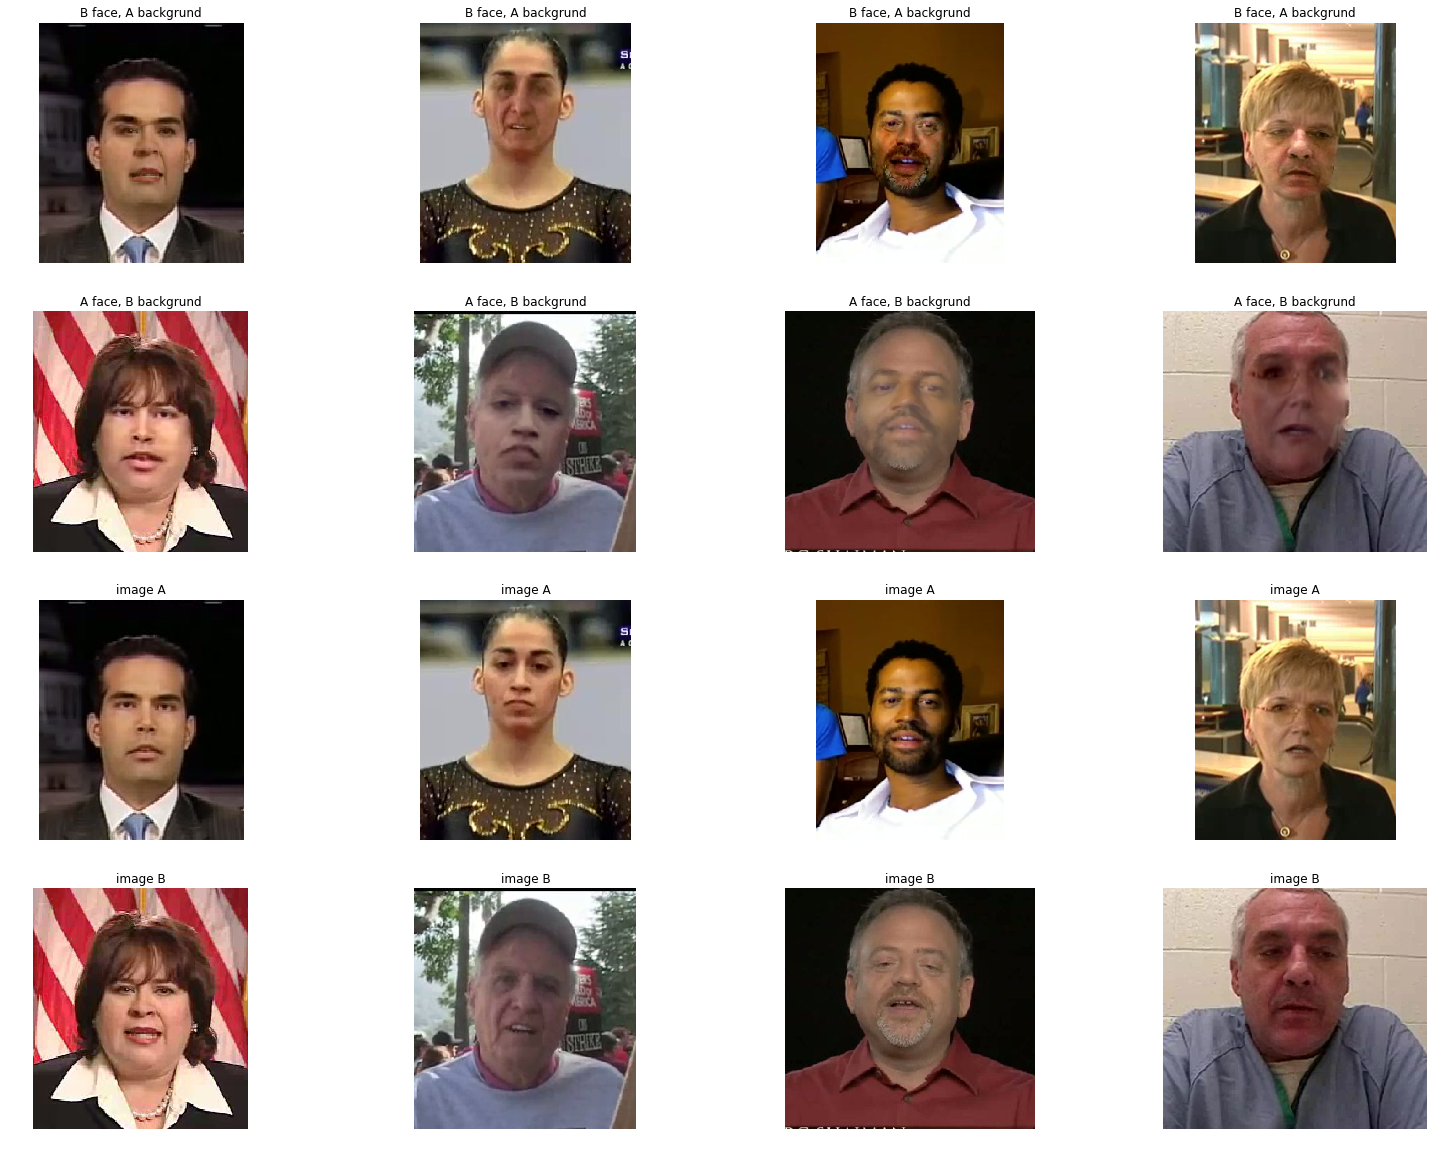

In [13]:
# take several pairs of almost frontal celebrity images, swap their faces and display
np.random.seed(7)

almost_frontal_shape_cluster_inds = [0,1,5,6,8,9,10,11,14,15,16,17,18,19,20]
almost_frontal_inds = np.nonzero([x in almost_frontal_shape_cluster_inds for x in cluster_assignment])[0]
almost_frontal_inds = np.array(list(set(almost_frontal_inds).intersection(set(shape_ind_large_face_only))))

num_pairs = 4

plt.figure(figsize=(22,16))
plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.98, wspace=0.05, hspace=0.2)
for k in range(num_pairs):

    # choose 2 candidate images
    some_frontal_image_inds = np.random.choice(frontal_inds,size=2)
    selected_videoID_A     = shape_ind_to_videoID_map[some_frontal_image_inds[0]][0]
    selected_video_frame_A = shape_ind_to_videoID_map[some_frontal_image_inds[0]][1]
    selected_videoID_B     = shape_ind_to_videoID_map[some_frontal_image_inds[1]][0]
    selected_video_frame_B = shape_ind_to_videoID_map[some_frontal_image_inds[1]][1]

    # load image A
    video_file_A = np.load(full_paths[selected_videoID_A])
    image_A = video_file_A['colorImages'][:,:,:,selected_video_frame_A]
    shape_A = video_file_A['landmarks2D'][:,:,selected_video_frame_A]
    shape_A = interpret_using_shape_model(ShapesPCAModel, shape_A)

    # load image B
    video_file_B = np.load(full_paths[selected_videoID_B])
    image_B = video_file_B['colorImages'][:,:,:,selected_video_frame_B]
    shape_B = video_file_B['landmarks2D'][:,:,selected_video_frame_B]
    shape_B = interpret_using_shape_model(ShapesPCAModel, shape_B)

    # swap faces
    A_embedded_into_B, B_embedded_into_A = face_swap(image_A, shape_A, image_B, shape_B)
    
    # plot
    plt.subplot(4, num_pairs, k + 1 + 0*num_pairs); plt.imshow(B_embedded_into_A); plt.title("B face, A backgrund"); plt.axis('off');
    plt.subplot(4, num_pairs, k + 1 + 1*num_pairs); plt.imshow(A_embedded_into_B); plt.title("A face, B backgrund"); plt.axis('off');
    plt.subplot(4, num_pairs, k + 1 + 2*num_pairs); plt.imshow(image_A); plt.title('image A'); plt.axis('off');
    plt.subplot(4, num_pairs, k + 1 + 3*num_pairs); plt.imshow(image_B); plt.title('image B'); plt.axis('off');

## This was the poor man's face swap. hope you enjoyed it!